In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gillespy2
from scipy.optimize import minimize


In [2]:
def CLE(beta2, k2, n2, alpha, dt):
    x = [x0]
    for i in range(len(t) - 1):
        dxi = np.random.normal(0, 1, 3) 
        x_curr = x[-1]
        
        

        F = (
            
            beta2 * (pow(x_curr, n2) / (pow(k2, n2) + pow(x_curr, n2))) -
            alpha * x_curr)
        
        G = (
            
            np.sqrt(beta2 * (pow(x_curr, n2) / (pow(k2, n2) + pow(x_curr, n2)))) * dxi[1] +
            np.sqrt(alpha * x_curr) * dxi[2])
        
        x_next = x_curr + dt * F + np.sqrt(dt) * G

        x = np.hstack([x, x_next])
    return x


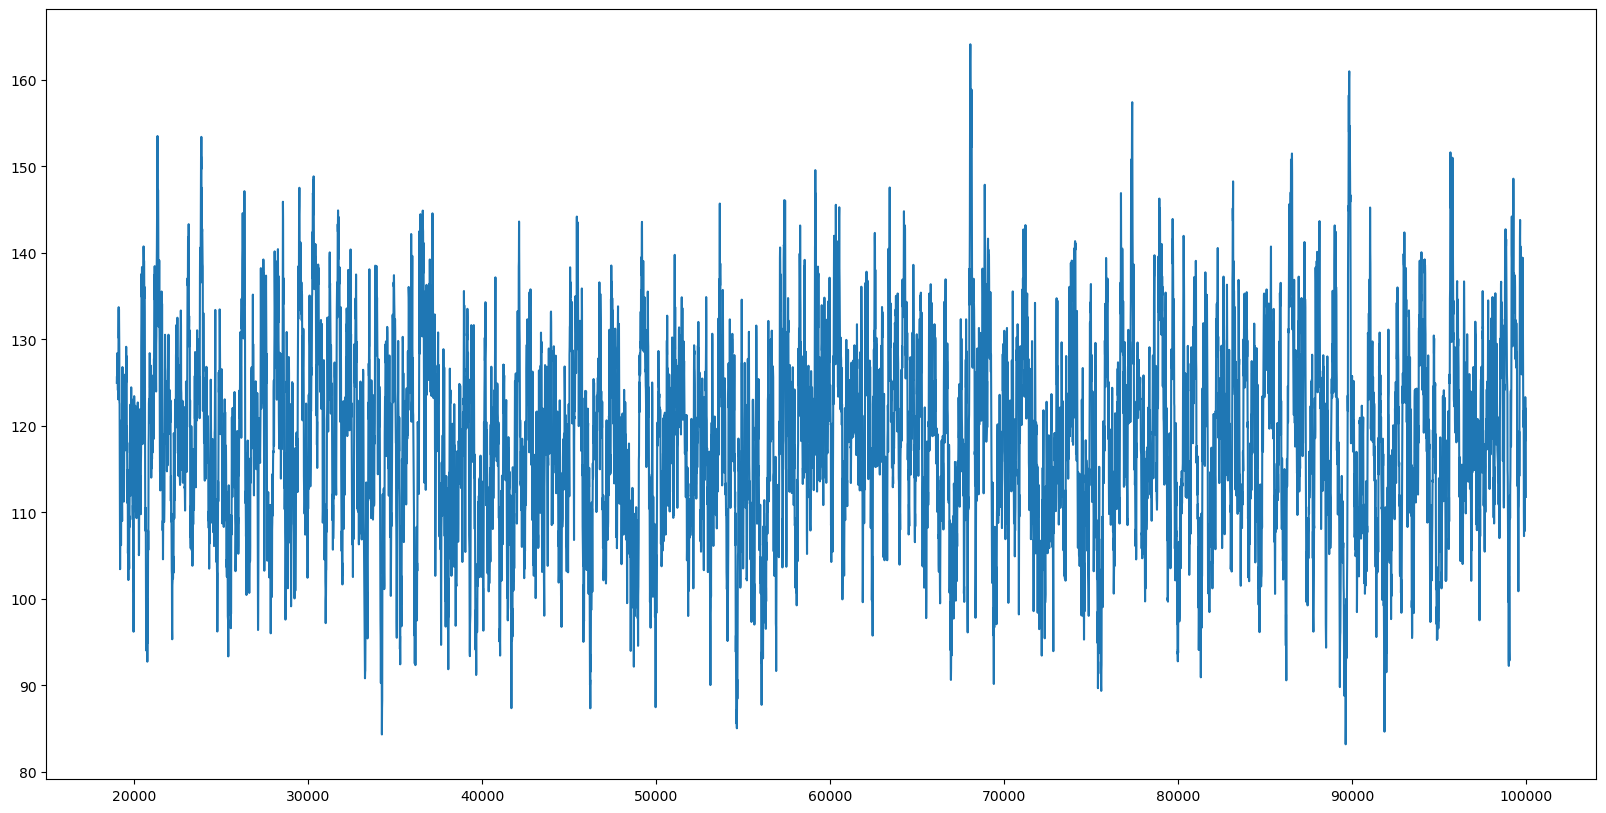

In [3]:

beta2=1.2
k2=1
n2=1
alpha=0.01
t = np.linspace(10000,100000,10000)
dt = t[1] - t[0]
x0=200
x_cle = CLE( beta2,k2, n2, alpha, dt)
x_cle_trimmed = x_cle[1000:]
t_trimmed = t[1000:]
plt.figure(figsize=(20, 10))
plt.plot(t_trimmed, x_cle_trimmed, label='cle')

In [4]:
def f_rep(x_cle_trimmed, k1, n1, beta1):
    return beta1 * (pow(k1, n1) / (pow(k1, n1) + pow(x_cle_trimmed, n1)))

def f_act(x_cle_trimmed, n2, k2, beta2):
    return beta2 * (pow(x_cle_trimmed, n2) / (pow(k2, n2) + pow(x_cle_trimmed, n2)))

def f_deg(x, alpha):
    return alpha * x_cle_trimmed

In [34]:
def fixed_point_act(x_cle_trimmed, k2, beta2, alpha):
    fact = f_act(x_cle_trimmed, n2, k2, beta2)
    fdeg = f_deg(x_cle_trimmed, alpha)
    
    diff_act = np.abs(fact - fdeg)
   
    fix_act_pt = x_cle_trimmed[np.where(diff_act < 0.005)[0][-1]]
   
    print('fix_act:', fix_act_pt)
   
    
    return fix_act_pt

#def fixed_point_rep(x_cle_trimmed, beta1, k1, n1, alpha):
    #frep = f_rep(x_cle_trimmed, k1, n1, beta1)
    #fdeg = f_deg(x_cle_trimmed, alpha)
    #diff_rep = np.abs(frep - fdeg)

    # Check if there are any points where diff_rep < 0.005
    #indices = np.where(diff_rep < 0.005)[0]
    
    #if len(indices) == 0:
        # No points satisfy the condition, handle this situation accordingly
        #print("No points satisfy the condition.")
        #return None
    #else:
        
        #fix_rep_pt = x_cle_trimmed[indices[-1]]
        #print('fix_rep:', fix_rep_pt)
        #return fix_rep_pt


In [35]:
from scipy.optimize import fixed_point

def fixed_point_rep(x_cle_trimmed, beta1, k1, n1, alpha):
    def equation_to_solve(x):
        frep = f_rep(x_cle_trimmed, k1, n1, beta1)
        fdeg = f_deg(x_cle_trimmed, alpha)
        return np.abs(frep - fdeg)

    # Initial guess for the root
    initial_guess = np.mean(x_cle_trimmed)

    # Use fixed_point to find the root
    fix_rep_pt = fixed_point(equation_to_solve, initial_guess)

    print("fix_rep_pt:", fix_rep_pt)

    if not np.isnan(fix_rep_pt).any():
        # Take the absolute value to ensure positivity
        fix_rep_pt = np.abs(fix_rep_pt)
        print('fix_rep:', fix_rep_pt)
        return fix_rep_pt[0]  # Extract the scalar value from the array
    else:
        print("Invalid fix_rep_pt found. Check your conditions or handle this case accordingly.")
        return None
  

In [24]:
fix_act_pt = fixed_point_act(x_cle_trimmed, k2, beta2, alpha)
#fix_rep_pt = fixed_point_rep(x_cle_trimmed, k1, beta1, alpha)


fix_act: 119.35673060728249


In [25]:
A=((-beta2*n2*pow(k2,n2)*pow(fix_act_pt,n2-1))/((pow(fix_act_pt,n2)+pow(k2,n2))**2))+alpha 
B=(beta2*pow(fix_act_pt,n2))/(pow(fix_act_pt,n2)+pow(k2,n2))+alpha*fix_act_pt

In [36]:
def A_r(fix_rep_pt, beta1, n1, K1, alpha):
    denominator = pow(fix_rep_pt, n1) + pow(K1, n1)
    
    # Handle division by zero or near-zero denominator
    if denominator == 0 or abs(denominator) < 1e-10:
        result = 0  # Set a default value or handle it according to your requirements
    else:
        numerator = beta1 * n1 * pow(K1, n1) * pow(fix_rep_pt, n1 - 1)
        result = (numerator / pow(denominator, 2)) + alpha
    
    print("A_r result:", result, "numerator:", numerator, "denominator:", denominator)
    
    return result

def B_r(fix_rep_pt, beta1, n1, K1, alpha):
    denominator = pow(fix_rep_pt, n1) + pow(K1, n1)
    
    # Handle division by zero or near-zero denominator
    if denominator == 0 or abs(denominator) < 1e-10:
        result = 0  # Set a default value or handle it according to your requirements
    else:
        numerator = beta1 * pow(K1, n1)
        result = (numerator / denominator) + alpha * fix_rep_pt
    
    print("B_r result:", result, "numerator:", numerator, "denominator:", denominator)
    
    return result


In [37]:
def cost_function(params, fix_act_pt, fix_rep_pt, x_cle_trimmed, n2, k2, beta2, alpha,n1):
    beta1, K1 = params
    
    
    A = ((-beta2 * n2 * pow(k2, n2) * pow(fix_act_pt, n2 - 1)) / ((pow(fix_act_pt, n2) + pow(k2, n2))**2)) + alpha
    B = (beta2 * pow(fix_act_pt, n2)) / (pow(fix_act_pt, n2) + pow(k2, n2)) + alpha * fix_act_pt
    
   
    A_r_val = A_r(fix_rep_pt, beta1, n1, K1, alpha)
    B_r_val = B_r(fix_rep_pt, beta1, n1, K1, alpha)
    
    # Check for NaN values and return a large value
    if np.isnan(A_r_val) or np.isnan(B_r_val):
        return 1e6
    
    
    expression_diff = np.abs(A / (2 * B) - A_r_val / (2 * B_r_val)) + np.abs(fix_act_pt - fix_rep_pt)

    return np.sum(expression_diff)


In [38]:
def constraint(params):
    beta1, K1 = params
    return [beta1, K1]

# Set up the constraints
constraints_definition = ({'type': 'ineq', 'fun': lambda params: params[0]},  # beta1 >= 0
                          {'type': 'ineq', 'fun': lambda params: params[1]},  # K1 >= 0
                          )  

# Set up the bounds
bounds_definition = [(0, None), (0, None)] 

# Initial guess for parameters (beta1, K1, n1)
n1=1
initial_guess = [0.1, 0.1]
fix_rep_pt = fixed_point_rep(x_cle_trimmed, initial_guess[0], initial_guess[1], n1, alpha)
# Minimize the cost function with constraints and bounds
result = minimize(cost_function, initial_guess, args=(fix_act_pt, fix_rep_pt, x_cle_trimmed, n2, k2, beta2, alpha,n1),
                  method='trust-constr', tol=1e-6, options={'maxiter': 1000},
                  constraints=constraints_definition, bounds=bounds_definition)

# Extract optimized parameters
optimized_params = result.x

# Print the optimized parameters
print("Optimized parameters (beta1, K1):", optimized_params)


fix_rep_pt: [1.24986213 1.25721022 1.25075427 ... 1.18318033 1.22000085 1.11778185]
fix_rep: [1.24986213 1.25721022 1.25075427 ... 1.18318033 1.22000085 1.11778185]
A_r result: 0.01548808935178174 numerator: 0.010000000000000002 denominator: 1.3498621291787805
B_r result: 0.019906785269307295 numerator: 0.010000000000000002 denominator: 1.3498621291787805
A_r result: 0.015488090169570779 numerator: 0.010000001490116121 denominator: 1.3498621291787805
B_r result: 0.01990678637320975 numerator: 0.010000001490116121 denominator: 1.3498621291787805
A_r result: 0.015488090048404457 numerator: 0.010000001490116121 denominator: 1.3498621440799417
B_r result: 0.019906786291430834 numerator: 0.010000001490116121 denominator: 1.3498621440799417
A_r result: 0.050086478828043846 numerator: 0.1005234785456453 denominator: 1.5835610074698716
B_r result: 0.07597800609064459 numerator: 0.1005234785456453 denominator: 1.5835610074698716
A_r result: 0.05008648081096415 numerator: 0.10052348351814608 den

/Users/anshigupta/anaconda3/lib/python3.11/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


A_r result: 0.38033209261950024 numerator: 18.45983359968715 denominator: 7.060219711327976
B_r result: 2.6271245613413208 numerator: 18.45983359968715 denominator: 7.060219711327976
A_r result: 0.38033209813787844 numerator: 18.459833874760108 denominator: 7.060219711327976
B_r result: 2.6271246003022832 numerator: 18.459833874760108 denominator: 7.060219711327976
A_r result: 0.38033208905494564 numerator: 18.459833874760108 denominator: 7.060219797909051
B_r result: 2.6271245682385325 numerator: 18.459833874760108 denominator: 7.060219797909051
A_r result: 0.38025191795882196 numerator: 18.485827713692963 denominator: 7.065953777114876
B_r result: 2.628681559476953 numerator: 18.485827713692963 denominator: 7.065953777114876
A_r result: 0.3802519234760055 numerator: 18.48582798915326 denominator: 7.065953777114876
B_r result: 2.6286815984611165 numerator: 18.48582798915326 denominator: 7.065953777114876
A_r result: 0.3802519143934539 numerator: 18.48582798915326 denominator: 7.065953

A_r result: 0.36550651183770055 numerator: 27.80154375471283 denominator: 8.843225018364059
B_r result: 3.15632270096628 numerator: 27.80154375471283 denominator: 8.843225018364059
A_r result: 0.3655065171351604 numerator: 27.801544168988116 denominator: 8.843225018364059
B_r result: 3.1563227478129092 numerator: 27.801544168988116 denominator: 8.843225018364059
A_r result: 0.3655065080376796 numerator: 27.801544168988116 denominator: 8.843225131513984
B_r result: 3.156322707587374 numerator: 27.801544168988116 denominator: 8.843225131513984
A_r result: 0.36549303402626876 numerator: 27.824114709425942 denominator: 8.846981722443187
B_r result: 3.1575389957780615 numerator: 27.824114709425942 denominator: 8.846981722443187
A_r result: 0.3654930393235278 numerator: 27.82411512403756 denominator: 8.846981722443187
B_r result: 3.1575390426428154 numerator: 27.82411512403756 denominator: 8.846981722443187
A_r result: 0.3654930302257561 numerator: 27.824115124037558 denominator: 8.846981835